# Outline

#### Stablish context and business objetive for the projet
    * define model outcome
    * define most relevant metrics
    * define how to select the "best model"
    * Define the general scoring function.   

#### Data Preprocessing according to the insights from the "Data Exploration" phase.
    * remove duplicate
    * remove inconsistencies
    * replace NaNs  
    * drop non-relevant features (optional)

#### Data Transformation: ready to train ML-models:
    * features-target separation
    * train-test split (unbalanced dataset)
    * data normalilzation
    * dataframe to array transformation

#### Stablish Null model  
    * Evaluate null model

#### Explore Base models: _logreg_, _svc_, _dt_, _knn_, ... _rf_. 
For each one:

    * Define the hyperparams of the model with GridSearch on the train_split (this will not be the final training)
    * Select the best hyper_params the model

#### Compare trained base models.  
    * Evaluate model metrics using the scoring function. Use the train_split. 


#### Train the best model.
    * select the "best model"
    * Train the model, from scratch, on the entire train_split at once (final base model training)
    * Use the entire dataset available (final training)

#### Final Model evaluation
    * Evaluate risk of overfitting by measuring the performance on the test_split (comparing with train_split performances).
    * optimize model with ROC-AUC (find best prob threshold)

#### Export trained model ready to wrap in API
    * Use joblib

# Context & Objectives

**Technical Objective:** Create a classifier to predict if a player will have career longer than 5 years.  

**Business Objective:** Determine if a player is a good opportunity of investment or not.  

* From the point of view of the investor it is important to identify as many good candidates as possible. This is translated into a model having a **_high recall_** for the positive class. A low recall model will limit the "growth capacity" of the investors.

* But it is also important for the investor to avoid "bad investments" (believing a player's career will be longer than 5 years, when it is not). This is translated into a model that besides having high recall, must have a high precision. A low precision model will result in investments made on the wrong players, which can not only limit the growth capacity of the investor but can also incur important "capital losses".



**Criteria for "best model":**
* For finding a model with high recall and high precision, the f1-score is a good metric.

## Scoring Function

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score

In [61]:
def score_classifier(dataset,classifier,labels):

    """
    performs 3 random trainings/tests to build a confusion matrix and prints results with precision and recall scores
    :param dataset: the dataset to work on
    :param classifier: the classifier to use
    :param labels: the labels used for training and validation
    :return:
    """

    # kf = KFold(n_splits=3,random_state=50,shuffle=True)
    kf = StratifiedKFold(n_splits=3,random_state=50,shuffle=True)    
    confusion_mat = np.zeros((2,2))
    recall, precision, f1 = 0, 0, 0

    for training_ids,test_ids in kf.split(dataset,labels):
        training_set = dataset[training_ids]
        training_labels = labels[training_ids]

        test_set = dataset[test_ids]
        test_labels = labels[test_ids]

        classifier.fit(training_set,training_labels)
        predicted_labels = classifier.predict(test_set)

        # confusion_mat = pd.crosstab(test_labels, predicted_labels, rownames = ['Reality'], colnames = ['predictions'])
        confusion_mat+=confusion_matrix(test_labels,predicted_labels, labels=[0,1])
        # recall += recall_score(test_labels, predicted_labels)
        recall += recall_score(test_labels, predicted_labels, average='binary')
        precision += precision_score(test_labels, predicted_labels, average='binary')
        f1 += f1_score(test_labels, predicted_labels, average='binary')
    
    recall/=3
    precision/=3
    f1/=3

    print(f"recall: \t{recall: .6f}")
    print(f"precision: \t{precision: .6f}")
    print(f"f1 score: \t{f1: .6f}")
    print("confusion matrix:\n",confusion_mat, '\n')

# Data Preprocessing

In [3]:
## import raw data
df = pd.read_csv(".\\nba_logreg.csv")
df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


#### Clean dataset

In [4]:
## Remove simple duplicates
df.drop_duplicates(inplace = True)

## Remove inconsistent observations
inconsistents = df.drop('TARGET_5Yrs', axis = 1).duplicated()
df.drop(df.loc[inconsistents,:].index, axis=0, inplace=True)

# replacing Nan values (only present when no 3 points attempts have been performed by a player)
df.fillna(0.0, inplace=True)

#### Drop non relevant features (Optional)

In [5]:
# irrelevant_features = ['FGA', '3PA', 'FTA', 'REB', 'FT%', '3P Made', '3PA']  ## from the correlation matrix insgihts
# irrelevant_features = ['3P Made', '3PA']  ## from the statistical tests insights
irrelevant_features = []

df.drop(irrelevant_features, axis=1, inplace=True)

df.head()

,Name,GP,MIN,PTS,FGM,FGA,FG%,3P Made,3PA,3P%,...,FTA,FT%,OREB,DREB,REB,AST,STL,BLK,TOV,TARGET_5Yrs
0,Brandon Ingram,36,27.4,7.4,2.6,7.6,34.7,0.5,2.1,25.0,...,2.3,69.9,0.7,3.4,4.1,1.9,0.4,0.4,1.3,0.0
1,Andrew Harrison,35,26.9,7.2,2.0,6.7,29.6,0.7,2.8,23.5,...,3.4,76.5,0.5,2.0,2.4,3.7,1.1,0.5,1.6,0.0
2,JaKarr Sampson,74,15.3,5.2,2.0,4.7,42.2,0.4,1.7,24.4,...,1.3,67.0,0.5,1.7,2.2,1.0,0.5,0.3,1.0,0.0
3,Malik Sealy,58,11.6,5.7,2.3,5.5,42.6,0.1,0.5,22.6,...,1.3,68.9,1.0,0.9,1.9,0.8,0.6,0.1,1.0,1.0
4,Matt Geiger,48,11.5,4.5,1.6,3.0,52.4,0.0,0.1,0.0,...,1.9,67.4,1.0,1.5,2.5,0.3,0.3,0.4,0.8,1.0


# Data transformation

#### Separate features & target

In [6]:
features = df.drop(['TARGET_5Yrs'], axis=1)
target = df['TARGET_5Yrs']

print(type(features))
print(type(target))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


#### Split Train & Test dataset

In [7]:
from sklearn.model_selection import train_test_split

data_train, data_test, y_train, y_test = train_test_split(features, target, test_size=0.2, shuffle=True, random_state=123)


In [8]:
## verify that proportion in the splits are more or less the same
y_train.value_counts(normalize=True)

TARGET_5Yrs
1.0    0.620459
0.0    0.379541
Name: proportion, dtype: float64

#### data formating: dataframes -> arrays 
* get feature names, feature values, target labels, players names, etc

In [9]:
# feature names (same for train and test datasets)
paramset = data_train.drop(['Name'],axis=1).columns.values

# extract player names, target values (labels) and train values
names_train = data_train['Name'].values.tolist()
labels_train = y_train.values
X_train_vals = data_train.drop(['Name'],axis=1).values

In [10]:
## Same for test dataset

# extract player names, target values (labels) and train values
names_test = data_test['Name'].values.tolist()
labels_test = y_test.values
X_test_vals = data_test.drop(['Name'],axis=1).values

#### Normalize datasets
* Scale data to [0-1] range

In [11]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

# fit scaler with the training set
X_train = scaler.fit_transform(X_train_vals)

# tranform the test data with the same scaler
X_test = scaler.transform(X_test_vals)

# Null Model

The Null model will predict always the moss common class seen on the training dataset.

In [12]:
## visualize most common class
y_train.value_counts()

TARGET_5Yrs
1.0    649
0.0    397
Name: count, dtype: int64

In [13]:
## define null model object
class null_model:
    def __init__(self):
        self.prediction = None

    def fit(self, X_train, y_train):
        dominant_class = pd.Series(y_train).value_counts().idxmax()
        self.prediction = dominant_class

    def predict(self, X_test):
        num_obs = len(X_test)
        return np.array([self.prediction for _ in range(num_obs)])

In [14]:
## Instantiate model, train it 
clf_null = null_model()
clf_null.fit(X_train, y_train)


## make new predictions
labels_pred = clf_null.predict(X_test)

**Null model scoring on _train set_:**

In [15]:
## Scoring function on train set

print(f"===== Null model =====")
score_classifier(X_train, clf_null, labels_train)
print("\n")

===== Null model =====
[[  0. 397.]
 [  0. 649.]]
recall: 1.0
precision: 0.6204591114185027
f1 score: 0.7657812230056115




**Null model evaluation on _test set_:**

In [16]:
## Evaluate performance on test set
cm = pd.crosstab(labels_test, labels_pred, rownames = ['Reality'], colnames = ['Prediction'])
display(cm)


## detailed report
from sklearn.metrics import classification_report
cr = classification_report(labels_test, labels_pred)
print(cr)


Prediction,1.0
Reality,
0.0,95
1.0,167


              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00        95
         1.0       0.64      1.00      0.78       167

    accuracy                           0.64       262
   macro avg       0.32      0.50      0.39       262
weighted avg       0.41      0.64      0.50       262



C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Ramiro\NBA_players\venv\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


# Base models

In [22]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import GridSearchCV

### Logistic regression

In [23]:
## instantiate model
clf = LogisticRegression()  

## grid search pre-optimization
params = {'C' : [0.7,0.9,1,2,3,4,5,6,7,8,9,10]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_lr = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

        params  mean_test_accuracy  mean_test_f1  mean_test_recall
0   {'C': 0.7}            0.706494      0.776662          0.822886
1   {'C': 0.9}            0.711269      0.779862          0.824413
2     {'C': 1}            0.711269      0.780186          0.825951
3     {'C': 2}            0.712231      0.780688          0.825951
4     {'C': 3}            0.714135      0.782565          0.829028
5     {'C': 4}            0.715092      0.782482          0.825951
6     {'C': 5}            0.715088      0.781806          0.822874
7     {'C': 6}            0.712221      0.780063          0.822874
8     {'C': 7}            0.714135      0.780879          0.821336
9     {'C': 8}            0.714135      0.780879          0.821336
10    {'C': 9}            0.710312      0.778318          0.819785
11   {'C': 10}            0.712226      0.779432          0.819785 

Best params: {'C': 3}


### Support Vector Machine

In [24]:
## instantiate model
clf = SVC()  

## grid search pre-optimization
params = {'C' : [0.1,1,10],
          'kernel' : ['rbf'],
          'gamma'  : [0.01, 0.1, 0.5, 1.0, 2.0]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_svc = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                                        params  mean_test_accuracy  \
0   {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}            0.620460   
1    {'C': 0.1, 'gamma': 0.1, 'kernel': 'rbf'}            0.620460   
2    {'C': 0.1, 'gamma': 0.5, 'kernel': 'rbf'}            0.698847   
3    {'C': 0.1, 'gamma': 1.0, 'kernel': 'rbf'}            0.707450   
4    {'C': 0.1, 'gamma': 2.0, 'kernel': 'rbf'}            0.700761   
5     {'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}            0.620460   
6      {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}            0.706498   
7      {'C': 1, 'gamma': 0.5, 'kernel': 'rbf'}            0.710303   
8      {'C': 1, 'gamma': 1.0, 'kernel': 'rbf'}            0.708416   
9      {'C': 1, 'gamma': 2.0, 'kernel': 'rbf'}            0.704598   
10   {'C': 10, 'gamma': 0.01, 'kernel': 'rbf'}            0.707455   
11    {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}            0.711265   
12    {'C': 10, 'gamma': 0.5, 'kernel': 'rbf'}            0.717015   
13    {'C': 10, 'gam

In [30]:
# other interesting models:
clf_svc_2 = SVC(C= 0.1, gamma= 0.5, kernel= 'rbf')
clf_svc_3 = SVC(C= 1, gamma= 0.01, kernel= 'rbf')    # this is probable as the null model


### K-Neighbors

In [31]:
## instantiate model
clf = KNeighborsClassifier()  

## grid search pre-optimization
params = {'n_neighbors' : [3,5,10,12,15,17,20,24]}

grid_clf = GridSearchCV(estimator = clf, 
                        param_grid = params, 
                        scoring = ['accuracy','f1', 'recall'], 
                        refit='f1')

grid = grid_clf.fit(X_train, labels_train)

print(pd.DataFrame.from_dict(grid.cv_results_).loc[:,['params', 'mean_test_accuracy', 'mean_test_f1', 'mean_test_recall']], '\n')


## Keep best model
clf_knn = grid_clf.best_estimator_
print("Best params:", grid_clf.best_params_)

                params  mean_test_accuracy  mean_test_f1  mean_test_recall
0   {'n_neighbors': 3}            0.651069      0.725363          0.744234
1   {'n_neighbors': 5}            0.665377      0.736273          0.753465
2  {'n_neighbors': 10}            0.677817      0.735429          0.722671
3  {'n_neighbors': 12}            0.688348      0.747482          0.744234
4  {'n_neighbors': 15}            0.683563      0.755224          0.787382
5  {'n_neighbors': 17}            0.686434      0.756349          0.785832
6  {'n_neighbors': 20}            0.684520      0.747515          0.753441
7  {'n_neighbors': 24}            0.686448      0.748041          0.751938 

Best params: {'n_neighbors': 17}


# Compared pre-selected Base models

In [63]:
models = [('Null model', clf_null),
          ('logistic regression', clf_lr),
          ('support vectors', clf_svc), 
          ('k-neighbors', clf_knn)]

for model_name, clf in models:
    print(f"===== {model_name} =====")
    score_classifier(X_train, clf, labels_train)
    print("\n")

===== Null model =====
recall: 	 1.000000
precision: 	 0.620459
f1 score: 	 0.765781
confusion matrix:
 [[  0. 397.]
 [  0. 649.]] 



===== logistic regression =====
recall: 	 0.825880
precision: 	 0.738019
f1 score: 	 0.779218
confusion matrix:
 [[206. 191.]
 [113. 536.]] 



===== support vectors =====
recall: 	 0.816721
precision: 	 0.747373
f1 score: 	 0.779672
confusion matrix:
 [[217. 180.]
 [119. 530.]] 



===== k-neighbors =====
recall: 	 0.776654
precision: 	 0.721764
f1 score: 	 0.747355
confusion matrix:
 [[202. 195.]
 [145. 504.]] 





# Select best model
* Support vectors machine has the highµest f1-score

In [35]:
best_model = clf_svc

In [36]:
## instantiate new model
best_params = best_model.get_params()
best_params['probability'] = True

clf_best = SVC(**best_params)


## Re-train the best model on the entire training dataset
clf_best.fit(X_train, labels_train)

## make prediction
labels_pred = clf_best.predict(X_test)
proba_pred = clf_best.predict_proba(X_test)

# Best model Evaluation

In [39]:
## check for overfitting risk

train_acc = clf_best.score(X_train, labels_train) 
test_acc = clf_best.score(X_test, labels_test)

print(f"Accuracy on train dataset = {train_acc: .4f}")
print(f"Accuracy on test dataset = {test_acc: .4f}")

Accuracy on train dataset =  0.7409
Accuracy on test dataset =  0.7290


In [40]:
## Evaluate performance on test set
cm = pd.crosstab(labels_test, labels_pred, rownames = ['Reality'], colnames = ['Prediction'])
display(cm)


## detailed report
from sklearn.metrics import classification_report
cr = classification_report(labels_test, labels_pred)
print(cr)

Prediction,0.0,1.0
Reality,,
0.0,50,45
1.0,26,141


              precision    recall  f1-score   support

         0.0       0.66      0.53      0.58        95
         1.0       0.76      0.84      0.80       167

    accuracy                           0.73       262
   macro avg       0.71      0.69      0.69       262
weighted avg       0.72      0.73      0.72       262



## Further model optimization

Optimal probability threshold =  0.6513
	 true positive rate =  0.7725
	 false positive rate =  0.3368


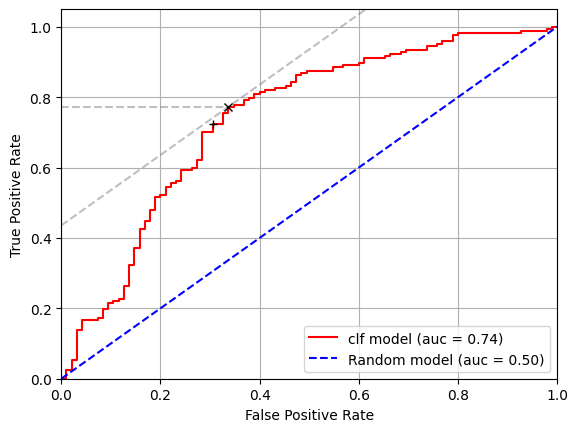

In [82]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(labels_test, proba_pred[:,1], pos_label = 1)
auc = auc(fpr, tpr)

# Optimal point is the touching point closer to the (1,0) corner. 
idx = (tpr-fpr).argmax() 
print(f"Optimal probability threshold = {thresholds[idx]: .4f}")
print(f"\t true positive rate = {tpr[idx]: .4f}")
print(f"\t false positive rate = {fpr[idx]: .4f}")

# models:
plt.plot(fpr, tpr, c = 'r', label = 'clf model (auc = %0.2f)' % auc)
plt.plot(fpr, fpr, c = 'b', label = 'Random model (auc = 0.50)', ls ='--')

# indicators: 
dy = tpr[idx]-fpr[idx]
plt.plot(fpr, fpr+dy, c = 'gray', alpha=0.5, ls ='--')
plt.axhline(y=tpr[idx], xmin=0, xmax=fpr[idx], color='gray', alpha=0.5, ls ='--')
plt.plot(fpr[idx], tpr[idx], c = 'k', marker = 'x')
plt.plot(fpr[50], tpr[50], c = 'k', marker = '+')

# formating:
plt.grid(visible=True)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.axis([0,1,0,1.05])
plt.legend()
plt.show()

**Notes:**

* The model can be improved a bit by changing the probability threshold.
* on the API use the model to predict probabilities and use the tunned threshold.
* check here how the metrics improve with this change
* the threshodl can be a risk parameter led to an investor to set as input.
* optimal model catches 77% of the good player, with a risk of 35% of investing in a bad player.

# Export trained Model

In [83]:
from joblib import dump, load
dump(clf_best, '.\\best_model.joblib')


['.\\best_model.joblib']